In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
# %matplotlib notebook
%matplotlib inline

In [2]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [3]:
body_part = "shoulder_right"
dataset = pd.read_csv('./data/' + body_part + '_elbow.log', delim_whitespace=True,
                          header=0)
dataset = dataset[(np.abs(stats.zscore(dataset)) < 3).all(axis=1)]

In [4]:
dataset = dataset.values[1:len(dataset)-1,0:]
# np.random.shuffle(dataset)

print('%d values'%(len(dataset)))
dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]
print('%d values after filtering outliers'%(len(dataset)))

euler_set = np.array(dataset[:,12:15])

for i in range(3):
    print('max euler ' + str(i) + ": " + str(np.amax(euler_set[:,i])))
    print('min euler ' + str(i) + ": " + str(np.amin(euler_set[:,i])))

sensors_set = np.array(dataset[:,:12])

161900 values
161900 values after filtering outliers
max euler 0: 1.4966784307150605
min euler 0: -2.436687779599465
max euler 1: 0.0586506795630642
min euler 1: -1.4732283099410808
max euler 2: 1.1236408759745284
min euler 2: -1.914713895676424


In [5]:
data_in_train = NormalizeData(sensors_set)
data_out_train = NormalizeData(euler_set)

## Data plotting

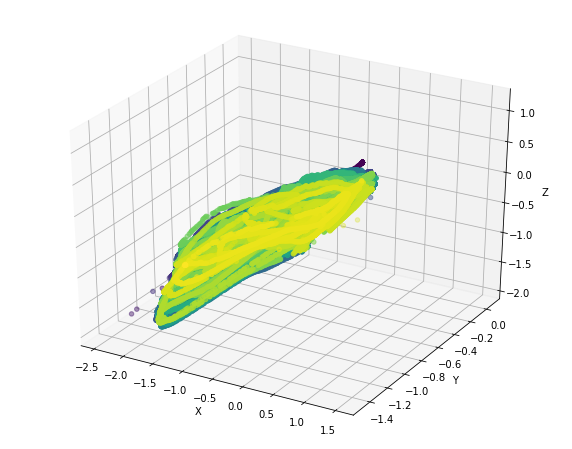

In [6]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(euler_set[:,0], euler_set[:,1], euler_set[:,2], c=np.arange(len(euler_set)))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
    
plt.show()

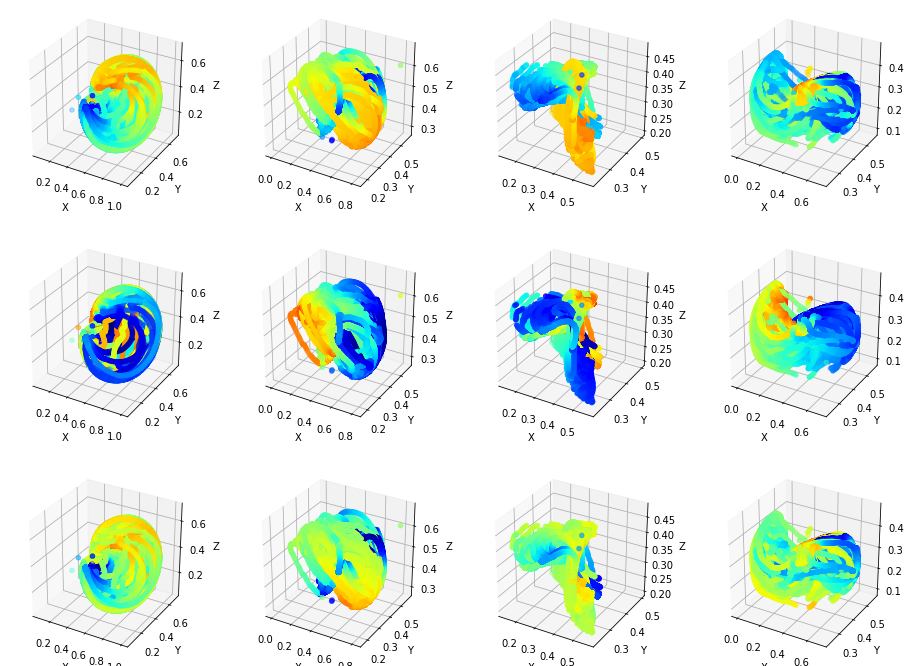

In [7]:
fig = plt.figure(figsize=(16,12))

for j in range(0, 3):
    for i in range(0, 4):
        ax = fig.add_subplot(3, 4, j*4+i+1, projection='3d')
        ax.scatter(data_in_train[:,i*3], data_in_train[:,i*3+1], data_in_train[:,i*3+2], 
                   c=data_out_train[:, j], cmap='jet')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
plt.show()
fig.savefig(body_part+'_plot.png', dpi=100, bbox_inches='tight')

## Dimension reduction

### tSNE

### PCA

In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_in_train)

In [9]:
pca.singular_values_

array([90.12804341, 69.46683982, 62.88766544])

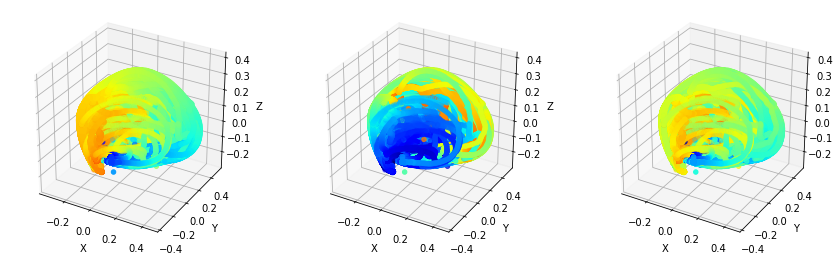

In [10]:
fig = plt.figure(figsize=(20,15))

for j in range(0, 3):
    ax = fig.add_subplot(3, 4, j+1, projection='3d')
    ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], 
               c=data_out_train[:, j], cmap='jet')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
plt.show()
fig.savefig(body_part+'_pca.png', dpi=100, bbox_inches='tight')